# Introduction

This notebook provides the main steps for the diagnosis of brain diseases using hypergraph neural networks. It contains the following sections.
- Preprocessing the original fMRI data
- Generating the vertex feature of hypergraph
- Hypergraph structure modeling
- Hypergraph semantic computation
- Prediction for brain disease

# Installing the deep hypergraph computation tool: DHG

```python
pip install dhg
```

## Test if your GPU is available

In [26]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1
True


In [27]:
if torch.cuda.is_available():
    print("CUDA is available. CUDA version:", torch.version.cuda)
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

CUDA is available. CUDA version: 12.4
Number of GPUs available: 1
Current GPU device: 0
GPU name: NVIDIA GeForce RTX 4090 Laptop GPU


# Importing the required library

In [28]:
import os
import logging

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import dhg
from dhg import Hypergraph, Graph
from dhg.nn import HGNNConv, GCNConv

from scipy.stats import ttest_1samp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, confusion_matrix
import pandas as pd
import scipy.io as sio

# Loading data
## Setting dataset path

In [29]:
root_folder = 'ABIDE1'
corr_folder = 'ABIDE1/correlation_aal'
phenotype_path = 'ABIDE1/Phenotypic_V1_0b_preprocessed1_871.csv'
rois_folder = 'ABIDE1/rois_aal'

# Hypergraph structure modeling

## Defining the AAL ROIs

In [30]:
aal_regions = {
    "#2001": {"english": "Precentral_L", "chinese": "左中央前回"},
    "#2002": {"english": "Precentral_R", "chinese": "右中央前回"},
    "#2101": {"english": "Frontal_Sup_L", "chinese": "左额上回"},
    "#2102": {"english": "Frontal_Sup_R", "chinese": "右额上回"},
    "#2111": {"english": "Frontal_Sup_Orb_L", "chinese": "左额上回眶部"},
    "#2112": {"english": "Frontal_Sup_Orb_R", "chinese": "右额上回眶部"},
    "#2201": {"english": "Frontal_Mid_L", "chinese": "左额中回"},
    "#2202": {"english": "Frontal_Mid_R", "chinese": "右额中回"},
    "#2211": {"english": "Frontal_Mid_Orb_L", "chinese": "左额中回眶部"},
    "#2212": {"english": "Frontal_Mid_Orb_R", "chinese": "右额中回眶部"},
    "#2301": {"english": "Frontal_Inf_Oper_L", "chinese": "左额下回操作部"},
    "#2302": {"english": "Frontal_Inf_Oper_R", "chinese": "右额下回操作部"},
    "#2311": {"english": "Frontal_Inf_Tri_L", "chinese": "左额下回三角部"},
    "#2312": {"english": "Frontal_Inf_Tri_R", "chinese": "右额下回三角部"},
    "#2321": {"english": "Frontal_Inf_Orb_L", "chinese": "左额下回眶部"},
    "#2322": {"english": "Frontal_Inf_Orb_R", "chinese": "右额下回眶部"},
    "#2331": {"english": "Rolandic_Oper_L", "chinese": "左Rolandic操作部"},
    "#2332": {"english": "Rolandic_Oper_R", "chinese": "右Rolandic操作部"},
    "#2401": {"english": "Supp_Motor_Area_L", "chinese": "左辅助运动区"},
    "#2402": {"english": "Supp_Motor_Area_R", "chinese": "右辅助运动区"},
    "#2501": {"english": "Olfactory_L", "chinese": "左嗅觉区"},
    "#2502": {"english": "Olfactory_R", "chinese": "右嗅觉区"},
    "#2601": {"english": "Frontal_Sup_Medial_L", "chinese": "左额上回内侧部"},
    "#2602": {"english": "Frontal_Sup_Medial_R", "chinese": "右额上回内侧部"},
    "#2611": {"english": "Frontal_Med_Orb_L", "chinese": "左额中回眶部"},
    "#2612": {"english": "Frontal_Med_Orb_R", "chinese": "右额中回眶部"},
    "#2701": {"english": "Rectus_L", "chinese": "左直回"},
    "#2702": {"english": "Rectus_R", "chinese": "右直回"},
    "#3001": {"english": "Insula_L", "chinese": "左岛叶"},
    "#3002": {"english": "Insula_R", "chinese": "右岛叶"},
    "#4001": {"english": "Cingulum_Ant_L", "chinese": "左前扣带回"},
    "#4002": {"english": "Cingulum_Ant_R", "chinese": "右前扣带回"},
    "#4011": {"english": "Cingulum_Mid_L", "chinese": "左中扣带回"},
    "#4012": {"english": "Cingulum_Mid_R", "chinese": "右中扣带回"},
    "#4021": {"english": "Cingulum_Post_L", "chinese": "左后扣带回"},
    "#4022": {"english": "Cingulum_Post_R", "chinese": "右后扣带回"},
    "#4101": {"english": "Hippocampus_L", "chinese": "左海马"},
    "#4102": {"english": "Hippocampus_R", "chinese": "右海马"},
    "#4111": {"english": "ParaHippocampal_L", "chinese": "左海马旁回"},
    "#4112": {"english": "ParaHippocampal_R", "chinese": "右海马旁回"},
    "#4201": {"english": "Amygdala_L", "chinese": "左杏仁核"},
    "#4202": {"english": "Amygdala_R", "chinese": "右杏仁核"},
    "#5001": {"english": "Calcarine_L", "chinese": "左距状裂"},
    "#5002": {"english": "Calcarine_R", "chinese": "右距状裂"},
    "#5011": {"english": "Cuneus_L", "chinese": "左楔前叶"},
    "#5012": {"english": "Cuneus_R", "chinese": "右楔前叶"},
    "#5021": {"english": "Lingual_L", "chinese": "左舌回"},
    "#5022": {"english": "Lingual_R", "chinese": "右舌回"},
    "#5101": {"english": "Occipital_Sup_L", "chinese": "左枕上回"},
    "#5102": {"english": "Occipital_Sup_R", "chinese": "右枕上回"},
    "#5201": {"english": "Occipital_Mid_L", "chinese": "左枕中回"},
    "#5202": {"english": "Occipital_Mid_R", "chinese": "右枕中回"},
    "#5301": {"english": "Occipital_Inf_L", "chinese": "左枕下回"},
    "#5302": {"english": "Occipital_Inf_R", "chinese": "右枕下回"},
    "#5401": {"english": "Fusiform_L", "chinese": "左梭状回"},
    "#5402": {"english": "Fusiform_R", "chinese": "右梭状回"},
    "#6001": {"english": "Postcentral_L", "chinese": "左中央后回"},
    "#6002": {"english": "Postcentral_R", "chinese": "右中央后回"},
    "#6101": {"english": "Parietal_Sup_L", "chinese": "左顶上回"},
    "#6102": {"english": "Parietal_Sup_R", "chinese": "右顶上回"},
    "#6201": {"english": "Parietal_Inf_L", "chinese": "左顶下回"},
    "#6202": {"english": "Parietal_Inf_R", "chinese": "右顶下回"},
    "#6211": {"english": "SupraMarginal_L", "chinese": "左缘上回"},
    "#6212": {"english": "SupraMarginal_R", "chinese": "右缘上回"},
    "#6221": {"english": "Angular_L", "chinese": "左角回"},
    "#6222": {"english": "Angular_R", "chinese": "右角回"},
    "#6301": {"english": "Precuneus_L", "chinese": "左楔前叶"},
    "#6302": {"english": "Precuneus_R", "chinese": "右楔前叶"},
    "#6401": {"english": "Paracentral_Lobule_L", "chinese": "左旁中央小叶"},
    "#6402": {"english": "Paracentral_Lobule_R", "chinese": "右旁中央小叶"},
    "#7001": {"english": "Caudate_L", "chinese": "左尾状核"},
    "#7002": {"english": "Caudate_R", "chinese": "右尾状核"},
    "#7011": {"english": "Putamen_L", "chinese": "左壳核"},
    "#7012": {"english": "Putamen_R", "chinese": "右壳核"},
    "#7021": {"english": "Pallidum_L", "chinese": "左苍白球"},
    "#7022": {"english": "Pallidum_R", "chinese": "右苍白球"},
    "#7101": {"english": "Thalamus_L", "chinese": "左丘脑"},
    "#7102": {"english": "Thalamus_R", "chinese": "右丘脑"},
    "#8101": {"english": "Heschl_L", "chinese": "左Heschl回"},
    "#8102": {"english": "Heschl_R", "chinese": "右Heschl回"},
    "#8111": {"english": "Temporal_Sup_L", "chinese": "左颞上回"},
    "#8112": {"english": "Temporal_Sup_R", "chinese": "右颞上回"},
    "#8121": {"english": "Temporal_Pole_Sup_L", "chinese": "左颞极上部"},
    "#8122": {"english": "Temporal_Pole_Sup_R", "chinese": "右颞极上部"},
    "#8201": {"english": "Temporal_Mid_L", "chinese": "左颞中回"},
    "#8202": {"english": "Temporal_Mid_R", "chinese": "右颞中回"},
    "#8211": {"english": "Temporal_Pole_Mid_L", "chinese": "左颞极中部"},
    "#8212": {"english": "Temporal_Pole_Mid_R", "chinese": "右颞极中部"},
    "#8301": {"english": "Temporal_Inf_L", "chinese": "左颞下回"},
    "#8302": {"english": "Temporal_Inf_R", "chinese": "右颞下回"},
    "#9001": {"english": "Cerebelum_Crus1_L", "chinese": "左小脑Crus1"},
    "#9002": {"english": "Cerebelum_Crus1_R", "chinese": "右小脑Crus1"},
    "#9011": {"english": "Cerebelum_Crus2_L", "chinese": "左小脑Crus2"},
    "#9012": {"english": "Cerebelum_Crus2_R", "chinese": "右小脑Crus2"},
    "#9021": {"english": "Cerebelum_3_L", "chinese": "左小脑3"},
    "#9022": {"english": "Cerebelum_3_R", "chinese": "右小脑3"},
    "#9031": {"english": "Cerebelum_4_5_L", "chinese": "左小脑4/5"},
    "#9032": {"english": "Cerebelum_4_5_R", "chinese": "右小脑4/5"},
    "#9041": {"english": "Cerebelum_6_L", "chinese": "左小脑6"},
    "#9042": {"english": "Cerebelum_6_R", "chinese": "右小脑6"},
    "#9051": {"english": "Cerebelum_7b_L", "chinese": "左小脑7b"},
    "#9052": {"english": "Cerebelum_7b_R", "chinese": "右小脑7b"},
    "#9061": {"english": "Cerebelum_8_L", "chinese": "左小脑8"},
    "#9062": {"english": "Cerebelum_8_R", "chinese": "右小脑8"},
    "#9071": {"english": "Cerebelum_9_L", "chinese": "左小脑9"},
    "#9072": {"english": "Cerebelum_9_R", "chinese": "右小脑9"},
    "#9081": {"english": "Cerebelum_10_L", "chinese": "左小脑10"},
    "#9082": {"english": "Cerebelum_10_R", "chinese": "右小脑10"},
    "#9100": {"english": "Vermis_1_2", "chinese": "小脑蚓部1/2"},
    "#9110": {"english": "Vermis_3", "chinese": "小脑蚓部3"},
    "#9120": {"english": "Vermis_4_5", "chinese": "小脑蚓部4/5"},
    "#9130": {"english": "Vermis_6", "chinese": "小脑蚓部6"},
    "#9140": {"english": "Vermis_7", "chinese": "小脑蚓部7"},
    "#9150": {"english": "Vermis_8", "chinese": "小脑蚓部8"},
    "#9160": {"english": "Vermis_9", "chinese": "小脑蚓部9"},
    "#9170": {"english": "Vermis_10", "chinese": "小脑蚓部10"},
}

In [31]:
file_list = os.listdir(rois_folder)

if file_list:
    first_file_path = os.path.join(rois_folder, file_list[0])
    print(f"Case：{first_file_path}")
    
    df = pd.read_csv(first_file_path, delimiter='\t')
    name_list = df.columns.values.tolist()
    print('Atlas name:{}'.format(name_list))
    
else:
    print("Empty Folder！")

Case：ABIDE1/rois_aal\Caltech_0051461_rois_aal.1D
Atlas name:['#2001', '#2002', '#2101', '#2102', '#2111', '#2112', '#2201', '#2202', '#2211', '#2212', '#2301', '#2302', '#2311', '#2312', '#2321', '#2322', '#2331', '#2332', '#2401', '#2402', '#2501', '#2502', '#2601', '#2602', '#2611', '#2612', '#2701', '#2702', '#3001', '#3002', '#4001', '#4002', '#4011', '#4012', '#4021', '#4022', '#4101', '#4102', '#4111', '#4112', '#4201', '#4202', '#5001', '#5002', '#5011', '#5012', '#5021', '#5022', '#5101', '#5102', '#5201', '#5202', '#5301', '#5302', '#5401', '#5402', '#6001', '#6002', '#6101', '#6102', '#6201', '#6202', '#6211', '#6212', '#6221', '#6222', '#6301', '#6302', '#6401', '#6402', '#7001', '#7002', '#7011', '#7012', '#7021', '#7022', '#7101', '#7102', '#8101', '#8102', '#8111', '#8112', '#8121', '#8122', '#8201', '#8202', '#8211', '#8212', '#8301', '#8302', '#9001', '#9002', '#9011', '#9012', '#9021', '#9022', '#9031', '#9032', '#9041', '#9042', '#9051', '#9052', '#9061', '#9062', '#9

## Hyperedge definition based on structure
The same structure (left and right) forms a hyperedge

In [32]:
structure_hyperedges = {
    "Precentral": ["#2001", "#2002"],
    "Frontal_Sup": ["#2101", "#2102"],
    "Frontal_Sup_Orb": ["#2111", "#2112"],
    "Frontal_Mid": ["#2201", "#2202"],
    "Frontal_Mid_Orb": ["#2211", "#2212"],
    "Frontal_Inf_Oper": ["#2301", "#2302"],
    "Frontal_Inf_Tri": ["#2311", "#2312"],
    "Frontal_Inf_Orb": ["#2321", "#2322"],
    "Rolandic_Oper": ["#2331", "#2332"],
    "Supp_Motor_Area": ["#2401", "#2402"],
    "Olfactory": ["#2501", "#2502"],
    "Frontal_Sup_Medial": ["#2601", "#2602"],
    "Frontal_Med_Orb": ["#2611", "#2612"],
    "Rectus": ["#2701", "#2702"],
    "Insula": ["#3001", "#3002"],
    "Cingulum_Ant": ["#4001", "#4002"],
    "Cingulum_Mid": ["#4011", "#4012"],
    "Cingulum_Post": ["#4021", "#4022"],
    "Hippocampus": ["#4101", "#4102"],
    "ParaHippocampal": ["#4111", "#4112"],
    "Amygdala": ["#4201", "#4202"],
    "Calcarine": ["#5001", "#5002"],
    "Cuneus": ["#5011", "#5012"],
    "Lingual": ["#5021", "#5022"],
    "Occipital_Sup": ["#5101", "#5102"],
    "Occipital_Mid": ["#5201", "#5202"],
    "Occipital_Inf": ["#5301", "#5302"],
    "Fusiform": ["#5401", "#5402"],
    "Postcentral": ["#6001", "#6002"],
    "Parietal_Sup": ["#6101", "#6102"],
    "Parietal_Inf": ["#6201", "#6202"],
    "SupraMarginal": ["#6211", "#6212"],
    "Angular": ["#6221", "#6222"],
    "Precuneus": ["#6301", "#6302"],
    "Paracentral_Lobule": ["#6401", "#6402"],
    "Caudate": ["#7001", "#7002"],
    "Putamen": ["#7011", "#7012"],
    "Pallidum": ["#7021", "#7022"],
    "Thalamus": ["#7101", "#7102"],
    "Heschl": ["#8101", "#8102"],
    "Temporal_Sup": ["#8111", "#8112"],
    "Temporal_Pole_Sup": ["#8121", "#8122"],
    "Temporal_Mid": ["#8201", "#8202"],
    "Temporal_Pole_Mid": ["#8211", "#8212"],
    "Temporal_Inf": ["#8301", "#8302"],
    "Cerebelum_Crus1": ["#9001", "#9002"],
    "Cerebelum_Crus2": ["#9011", "#9012"],
    "Cerebelum_3": ["#9021", "#9022"],
    "Cerebelum_4_5": ["#9031", "#9032"],
    "Cerebelum_6": ["#9041", "#9042"],
    "Cerebelum_7b": ["#9051", "#9052"],
    "Cerebelum_8": ["#9061", "#9062"],
    "Cerebelum_9": ["#9071", "#9072"],
    "Cerebelum_10": ["#9081", "#9082"],
    "Vermis_1_2": ["#9100"],
    "Vermis_3": ["#9110"],
    "Vermis_4_5": ["#9120"],
    "Vermis_6": ["#9130"],
    "Vermis_7": ["#9140"],
    "Vermis_8": ["#9150"],
    "Vermis_9": ["#9160"],
    "Vermis_10": ["#9170"],
}

## Hyperedge definition based on functional knowledge
 Functional networks are defined here as example functional networks, which need to be adapted to specific functional mappings in real applications

In [33]:
functional_hyperedges = {
    "Visuospatial": ["#5001", "#5002", "#5011", "#5012", "#5021", "#5022", "#5101", "#5102",
                     "#5201", "#5202", "#5301", "#5302", "#5401", "#5402"],
    "Motor": ["#2001", "#2002", "#6001", "#6002", "#6101", "#6102", "#6201", "#6202",
              "#6301", "#6302", "#6401", "#6402", "#7001", "#7002", "#7011", "#7012",
              "#7021", "#7022", "#7101", "#7102", "#9001", "#9002", "#9011", "#9012",
              "#9021", "#9022", "#9031", "#9032", "#9041", "#9042", "#9051", "#9052",
              "#9061", "#9062", "#9071", "#9072", "#9081", "#9082"],
    "Default_Mode": ["#6301", "#6302", "#7001", "#7002", "#7101", "#7102"],  
    "Auditory": ["#8101", "#8102", "#8111", "#8112", "#8121", "#8122"],
    "Limbic": ["#4001", "#4002", "#4011", "#4012", "#4021", "#4022",
               "#4101", "#4102", "#4111", "#4112", "#4201", "#4202"],
    "Executive": ["#2101", "#2102", "#2201", "#2202", "#2211", "#2212",
                  "#2301", "#2302", "#2311", "#2312", "#2321", "#2322"],
    "Language": ["#6211", "#6212", "#6221", "#6222", "#8211", "#8212",
                "#8301", "#8302"],  
}

## Hyperedge definition based on anatomical structural partitions

In [34]:
anatomical_hyperedges = {
    "Frontal_Lobe": [
        "#2001", "#2002", "#2101", "#2102", "#2111", "#2112", "#2201", "#2202",
        "#2211", "#2212", "#2301", "#2302", "#2311", "#2312", "#2321", "#2322",
        "#2331", "#2332", "#2401", "#2402", "#2501", "#2502", "#2601", "#2602",
        "#2611", "#2612", "#2701", "#2702"
    ],
    "Parietal_Lobe": [
        "#6001", "#6002", "#6101", "#6102", "#6201", "#6202", "#6211", "#6212",
        "#6221", "#6222", "#6301", "#6302", "#6401", "#6402"
    ],
    "Temporal_Lobe": [
        "#8101", "#8102", "#8111", "#8112", "#8121", "#8122", "#8201", "#8202",
        "#8211", "#8212", "#8301", "#8302"
    ],
    "Occipital_Lobe": [
        "#5001", "#5002", "#5011", "#5012", "#5021", "#5022", "#5101", "#5102",
        "#5201", "#5202", "#5301", "#5302", "#5401", "#5402"
    ],
    "Insula": ["#3001", "#3002"],
    "Cingulum": ["#4001", "#4002", "#4011", "#4012", "#4021", "#4022"],
    "Limbic_System": ["#4101", "#4102", "#4111", "#4112", "#4201", "#4202"],
    "Subcortical_Structures": ["#7001", "#7002", "#7011", "#7012", "#7021", "#7022", "#7101", "#7102"],
    "Cerebellum": [
        "#9001", "#9002", "#9011", "#9012", "#9021", "#9022", "#9031", "#9032",
        "#9041", "#9042", "#9051", "#9052", "#9061", "#9062", "#9071", "#9072",
        "#9081", "#9082"
    ],
    "Vermis": [
        "#9100", "#9110", "#9120", "#9130", "#9140", "#9150", "#9160", "#9170"
    ],
}

## Hyperedge definitions based on Harvard-Oxford partitions

In [35]:
harvard_oxford_hyperedges = {
    "Harvard_Oxford_Frontal": ["#2101", "#2102", "#2201", "#2202", "#2301", "#2302"],
    "Harvard_Oxford_Parietal": ["#6001", "#6002", "#6101", "#6102", "#6201", "#6202"],
    "Harvard_Oxford_Temporal": ["#8101", "#8102", "#8111", "#8112", "#8201", "#8202"],
    "Harvard_Oxford_Occipital": ["#5001", "#5002", "#5011", "#5012", "#5201", "#5202"],
    "Harvard_Oxford_Subcortical": ["#7001", "#7002", "#7101", "#7102"],
    "Harvard_Oxford_Limbic": ["#4001", "#4002", "#4101", "#4102", "#4201", "#4202"],
    "Harvard_Oxford_Cingulate": ["#4011", "#4012", "#4021", "#4022"],
    "Harvard_Oxford_Insula": ["#3001", "#3002"],
    "Harvard_Oxford_Cerebellum": ["#9001", "#9002", "#9011", "#9012", "#9021", "#9022",
                                   "#9031", "#9032", "#9041", "#9042", "#9051", "#9052",
                                   "#9061", "#9062", "#9071", "#9072", "#9081", "#9082",
                                   "#9100", "#9110", "#9120", "#9130", "#9140", "#9150",
                                   "#9160", "#9170"],
}

## Hyperedge definition based on Desikan-Killiany partitioning

In [36]:
desikan_killiany_hyperedges = {
    "DK_Frontal": ["#2101", "#2102", "#2201", "#2202", "#2301", "#2302", "#2311", "#2312", "#2321", "#2322"],
    "DK_Parietal": ["#6001", "#6002", "#6101", "#6102", "#6201", "#6202", "#6211", "#6212", "#6221", "#6222"],
    "DK_Temporal": ["#8101", "#8102", "#8111", "#8112", "#8121", "#8122", "#8201", "#8202", "#8211", "#8212",
                    "#8301", "#8302"],
    "DK_Occipital": ["#5001", "#5002", "#5011", "#5012", "#5021", "#5022", "#5101", "#5102",
                     "#5201", "#5202", "#5301", "#5302", "#5401", "#5402"],
    "DK_Subcortical": ["#7001", "#7002", "#7011", "#7012", "#7021", "#7022", "#7101", "#7102"],
    "DK_Cingulate": ["#4001", "#4002", "#4011", "#4012", "#4021", "#4022"],
    "DK_Limbic": ["#4101", "#4102", "#4111", "#4112", "#4201", "#4202"],
    "DK_Insula": ["#3001", "#3002"],
    "DK_Cerebellum": ["#9001", "#9002", "#9011", "#9012", "#9021", "#9022",
                       "#9031", "#9032", "#9041", "#9042", "#9051", "#9052",
                       "#9061", "#9062", "#9071", "#9072", "#9081", "#9082",
                       "#9100", "#9110", "#9120", "#9130", "#9140", "#9150",
                       "#9160", "#9170"],
}

## Hyperedge definitions based on Yeo network partitions

In [37]:
yeo_seven_network_hyperedges = {
    "Yeo_Ventral_Default": ["#6301", "#6302", "#6401", "#6402"],
    "Yeo_Limbic": ["#4001", "#4002", "#4011", "#4012", "#4021", "#4022",
                   "#4101", "#4102", "#4111", "#4112", "#4201", "#4202"],
    "Yeo_Default_Mode": ["#6301", "#6302", "#7001", "#7002", "#7101", "#7102"],  # 示例
    "Yeo_Motor": ["#2001", "#2002", "#6001", "#6002", "#6101", "#6102",
                 "#6201", "#6202", "#6401", "#6402"],
    "Yeo_Salience": ["#3001", "#3002", "#8101", "#8102"],
    "Yeo_Central_Executive": ["#2101", "#2102", "#2201", "#2202", "#2301", "#2302",
                              "#2311", "#2312", "#2321", "#2322"],
    "Yeo_Visual": ["#5001", "#5002", "#5011", "#5012", "#5021", "#5022",
                  "#5101", "#5102", "#5201", "#5202", "#5301", "#5302", "#5401", "#5402"],
    "Yeo_Auditory": ["#8101", "#8102", "#8111", "#8112", "#8121", "#8122"],
}

## Formulating the different typies of hyperedge

In [38]:
s_e_list = [tuple([name_list.index(v) for v in e]) for e in structure_hyperedges.values()]
f_e_list = [tuple([name_list.index(v) for v in e]) for e in functional_hyperedges.values()]
a_e_list = [tuple([name_list.index(v) for v in e]) for e in anatomical_hyperedges.values()]
h_e_list = [tuple([name_list.index(v) for v in e]) for e in harvard_oxford_hyperedges.values()]
d_e_list = [tuple([name_list.index(v) for v in e]) for e in desikan_killiany_hyperedges.values()]
y_e_list = [tuple([name_list.index(v) for v in e]) for e in yeo_seven_network_hyperedges.values()]

print('Brain hyperedges:{}'.format(s_e_list))
print('Functional hyperedges:{}'.format(f_e_list))
print('Structure hyperedges:{}'.format(a_e_list))
print('HO atlas hyperedges:{}'.format(h_e_list))
print('DK hyperedges:{}'.format(d_e_list))
print('Yeo hyperedges:{}'.format(y_e_list))

Brain hyperedges:[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15), (16, 17), (18, 19), (20, 21), (22, 23), (24, 25), (26, 27), (28, 29), (30, 31), (32, 33), (34, 35), (36, 37), (38, 39), (40, 41), (42, 43), (44, 45), (46, 47), (48, 49), (50, 51), (52, 53), (54, 55), (56, 57), (58, 59), (60, 61), (62, 63), (64, 65), (66, 67), (68, 69), (70, 71), (72, 73), (74, 75), (76, 77), (78, 79), (80, 81), (82, 83), (84, 85), (86, 87), (88, 89), (90, 91), (92, 93), (94, 95), (96, 97), (98, 99), (100, 101), (102, 103), (104, 105), (106, 107), (108,), (109,), (110,), (111,), (112,), (113,), (114,), (115,)]
Functional hyperedges:[(42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55), (0, 1, 56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107), (66, 67, 70, 71, 76, 77), (78, 79, 80, 81, 82, 83), (30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41), (2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14

# Building HGNN model with DHG
## Hypergraph feature

In [39]:
# loading phenotype file
phenotype = pd.read_csv(phenotype_path)
phenotype.head()

,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
1,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
3,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
4,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1


In [40]:
subject_list = phenotype['SUB_ID']

# loading label
label = phenotype['DX_GROUP']
lbl = torch.tensor(label, dtype=torch.int64)-1

In [41]:
# Define the note feature as the correlation vertec of each ROI
all_networks = []
for subject in subject_list:
    case_path = os.path.join(corr_folder, str(subject) + '_aal_correlation.mat')
    fm = sio.loadmat(case_path)['connectivity']
    all_networks.append(fm)
features = np.array(all_networks)
print('Functional matrix for case 1:\n{}'.format(features[1]))

Functional matrix for case 1:
[[ 1.          0.64909597  0.4284823  ...  0.35835329  0.23089749
  -0.31452676]
 [ 0.64909597  1.          0.4604474  ...  0.35773846  0.13330576
  -0.23209806]
 [ 0.4284823   0.4604474   1.         ...  0.3066132   0.10049477
  -0.15634422]
 ...
 [ 0.35835329  0.35773846  0.3066132  ...  1.          0.67067347
  -0.05909887]
 [ 0.23089749  0.13330576  0.10049477 ...  0.67067347  1.
   0.02604374]
 [-0.31452676 -0.23209806 -0.15634422 ... -0.05909887  0.02604374
   1.        ]]


## Hypergraph incidence matrix

In [42]:
Hypergraph_list = []
for feature in features:
    hg = Hypergraph.from_feature_kNN(torch.tensor(feature), k=3)
    hg.add_hyperedges(h_e_list)
    hg.add_hyperedges(d_e_list)
    Hypergraph_list.append(hg)
Hypergraph_list = np.array(Hypergraph_list)
print('Hypergraph list:\n {}'.format(Hypergraph_list))

Hypergraph list:
 [Hypergraph(num_v=116, num_e=109) Hypergraph(num_v=116, num_e=113)
 Hypergraph(num_v=116, num_e=108) Hypergraph(num_v=116, num_e=119)
 Hypergraph(num_v=116, num_e=109) Hypergraph(num_v=116, num_e=117)
 Hypergraph(num_v=116, num_e=116) Hypergraph(num_v=116, num_e=111)
 Hypergraph(num_v=116, num_e=110) Hypergraph(num_v=116, num_e=114)
 Hypergraph(num_v=116, num_e=109) Hypergraph(num_v=116, num_e=112)
 Hypergraph(num_v=116, num_e=107) Hypergraph(num_v=116, num_e=113)
 Hypergraph(num_v=116, num_e=113) Hypergraph(num_v=116, num_e=109)
 Hypergraph(num_v=116, num_e=112) Hypergraph(num_v=116, num_e=113)
 Hypergraph(num_v=116, num_e=110) Hypergraph(num_v=116, num_e=114)
 Hypergraph(num_v=116, num_e=114) Hypergraph(num_v=116, num_e=112)
 Hypergraph(num_v=116, num_e=108) Hypergraph(num_v=116, num_e=110)
 Hypergraph(num_v=116, num_e=105) Hypergraph(num_v=116, num_e=110)
 Hypergraph(num_v=116, num_e=110) Hypergraph(num_v=116, num_e=111)
 Hypergraph(num_v=116, num_e=111) Hypergraph

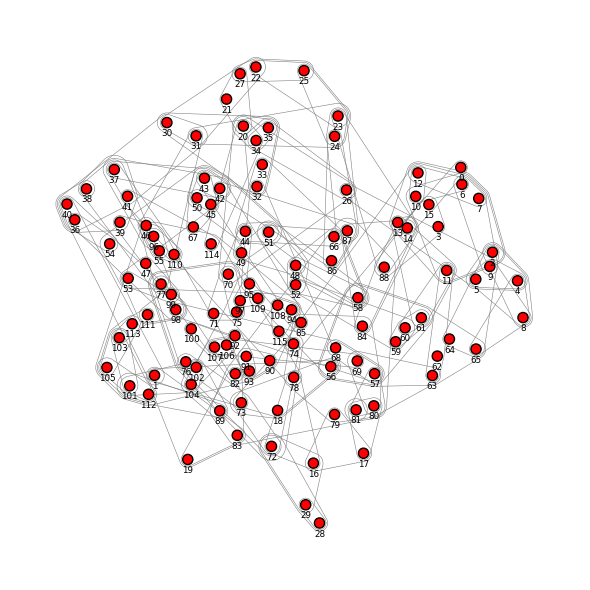

In [43]:
v_labels = [str(i) for i in np.arange(0, 116)]
hg.draw(v_label=v_labels)

# Define the matric

In [44]:
def calculate_metrics(trues, preds):
    """
    计算 Accuracy, Sensitivity, Specificity 的函数

    Args:
        trues: 真实标签
        preds: 预测标签

    Returns:
        acc: 准确率
        sen: 灵敏度
        spe: 特异性
    """
    # ACC
    acc = accuracy_score(trues, preds)
    
    # SEN (macro-average recall)
    sen = recall_score(trues, preds, average='macro')

    # SPE
    if len(set(trues)) > 1:
        cm = confusion_matrix(trues, preds)  # 混淆矩阵
        tn = cm[0, 0]  # 真负例
        fp = cm[0, 1]  # 假正例
        spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        spe = 0.5  # 类别不够时，默认特异性为 0.5

    return acc, sen, spe

# Define the trainig and evaluation function

In [54]:
def train_and_evaluate(
    model,
    n,                           # 训练样本数量
    k,                           # 测试样本数量
    optimizer,
    device,
    epochs,
    y_train,
    X_train,
    Hypergraph_train,
    y_test,
    X_test,
    Hypergraph_test,
    batch_size=8                 # 添加 batch_size
):
    """
    使用批量训练(batch training)的模式来训练并评估模型
    """
    model.train()
    epoch_losses = []
    best_test_acc, best_test_sen, best_test_spe = 0, 0, 0

    for epoch_i in range(epochs):
        total_loss = 0.0
        model.train()

        indices = np.arange(n)
        np.random.shuffle(indices)  
        for start_idx in range(0, n, batch_size):
            end_idx = min(start_idx + batch_size, n)
            batch_indices = indices[start_idx:end_idx]

            optimizer.zero_grad()  
            batch_loss = 0.0

            for j in batch_indices:
                X = torch.tensor(X_train[j], dtype=torch.float32).to(device)
                H = Hypergraph_train[j].to(device)
                y_train_tensor = y_train[j].to(device)

                out = model(X, H)
                loss_j = F.cross_entropy(out, y_train_tensor)
                batch_loss += loss_j

            batch_loss = batch_loss / len(batch_indices)

            batch_loss.backward()
            optimizer.step()

            total_loss += batch_loss.item() * len(batch_indices)

        epoch_loss = total_loss / n
        epoch_losses.append(epoch_loss)

        train_acc, train_sen, train_spe = evaluate(
            model, device, X_train, y_train, Hypergraph_train, n
        )
        logging.info(
            f"(Train) | Epoch={epoch_i:03d}, loss={epoch_loss:.4f}, "
            f"train_acc={train_acc*100:.2f}, train_sen={train_sen*100:.2f}, train_spe={train_spe*100:.2f}"
        )

        if (epoch_i + 1) % 1 == 0:
            test_acc, test_sen, test_spe = evaluate(
                model, device, X_test, y_test, Hypergraph_test, k
            )
            if test_acc > best_test_acc:
                best_test_acc, best_test_sen, best_test_spe = test_acc, test_sen, test_spe

            logging.info(
                f"\033[92m(Train Epoch {epoch_i}), test_acc={test_acc * 100:.2f}, "
                f"test_sen={test_sen * 100:.2f}, test_spe={test_spe * 100:.2f}\033[0m"
            )

    return best_test_acc, best_test_sen, best_test_spe


def evaluate(model, device, X_data, y_data, Hypergraph_data, k):  # k is the number of incoming samples
    model.eval()
    preds, trues, preds_prob = [], [], []

    for j in range(k):
        X = torch.tensor(X_data[j], dtype=torch.float32).to(device)
        H = Hypergraph_data[j].to(device)
        y_tensor = y_data[j].to(device)

        out = model(X, H)

        prob = torch.exp(out)
        pred = prob.max(dim=0)[1]
        pred = [pred.item()] if pred.dim() == 0 else pred.cpu().tolist()
        preds += pred

        preds_prob += [prob[1].item()]

        label = [y_tensor.item()] if y_tensor.dim() == 0 else y_tensor.cpu().tolist()
        trues += label

    acc, sen, spe = calculate_metrics(trues, preds)
    return acc, sen, spe

# HGNN Training

## HGNN model

In [55]:
class HGNN(nn.Module):
    r"""The GCN model proposed in Semi-Supervised Classification with Graph Convolutional Networks <https://arxiv.org/pdf/1609.02907>_ paper (ICLR 2017).

    Args:
        `in_channels (int): :math:C_{in} is the number of input channels.
        `hid_channels (int): :math:C_{hid} is the number of hidden channels.
        `num_classes (int): The Number of class of the classification task.
        `use_bn (bool): If set to True, use batch normalization. Defaults to False.
        `drop_rate (float): Dropout ratio. Defaults to 0.5.
    """

    def __init__(self,
                 in_channels: int,
                 hid_channels: int,
                 num_classes: int,
                 mlp_hid_channels: int,
                 use_bn: bool = False,
                 drop_rate: float = 0.5,
                 pooling_strategy: str = "concat"
                 ) -> None:
        super().__init__()
        self.pooling_strategy = pooling_strategy

        self.drop_rate = drop_rate  
        self.layers = nn.ModuleList()
        self.layers.append(HGNNConv(in_channels, hid_channels, use_bn=use_bn, drop_rate=drop_rate))
        self.layers.append(nn.Dropout(drop_rate))
        self.layers.append(HGNNConv(hid_channels, mlp_hid_channels, use_bn=use_bn, is_last=True))

        if pooling_strategy == "concat":
            mlp_input_dim = num_classes * 116  
        else:
            mlp_input_dim = mlp_hid_channels

        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, mlp_hid_channels),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(mlp_hid_channels, num_classes)  # Output layer for binary classification
        )

    def forward(self, X: torch.Tensor, hg: "dhg.Hypergraph") -> torch.Tensor:
        r"""The forward function.

        Args:
            `X (torch.Tensor): Input vertex feature matrix. Size :math:(N, C_{in}).
            `g (dhg.Graph): The graph structure that contains :math:N vertices.
        """
        for layer in self.layers:
            if isinstance(layer, HGNNConv):
                X = layer(X, hg)
            else:
                X = layer(X)
        if self.pooling_strategy == "mean":
            X = X.mean(dim=0)
        elif self.pooling_strategy == "sum":
            X = X.sum(dim=0)
        elif self.pooling_strategy == "concat":
            X = X.view(-1)
        out = self.mlp(X)
        return out

## HGNN training

In [56]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:{}'.format(device))

logging.basicConfig(level=logging.INFO)

device:cuda


In [57]:
K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=2024)
epoch = 100
lr = 0.0001

In [58]:
# how to build the hgnn model
# hgnn = HGNN(
#         in_channels=116,  
#         hid_channels=32, 
#         num_classes=2,
#         mlp_hid_channels=32,
#         use_bn=False,
#         drop_rate=0.4,
#         pooling_strategy="concat",
#     )

# print(hgnn)

In [59]:
all_acc, all_sen, all_spe = [], [], []
for fold, (train_index, test_index) in enumerate(kf.split(features, lbl)):
    print(f"Fold {fold + 1}/{K}")
    
    hgnn = HGNN(
        in_channels=116,  
        hid_channels=116, 
        num_classes=2,
        mlp_hid_channels=64,
        use_bn=False,
        drop_rate=0.6,
        pooling_strategy="sum",
    )
    hgnn = hgnn.to(device)
    optimizer = optim.Adam(hgnn.parameters(), lr=lr, weight_decay=1e-5)
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = lbl[train_index], lbl[test_index]
    HG_train, HG_test = Hypergraph_list[train_index], Hypergraph_list[test_index]
    
    # Evaluate the model on the test set
    test_acc, test_sen, test_spe = train_and_evaluate(hgnn, len(train_index), len(test_index), optimizer, device,
                                                          epoch, y_train, X_train, HG_train, y_test, X_test,
                                                          HG_test,1)

    logging.info(f'(Initial Performance Last Epoch) | test_acc={(test_acc * 100):.2f}, '
                 f'test_sen={(test_sen * 100):.2f}, test_spe={(test_spe * 100):.2f}, \n'
                 )
    # Store metrics for this fold
    all_acc.append(test_acc)
    all_sen.append(test_sen)
    all_spe.append(test_spe)

Fold 1/5


INFO:root:(Train) | Epoch=000, loss=1.2039, train_acc=54.02, train_sen=50.46, train_spe=2.80
INFO:root:(Train Epoch 0), test_acc=56.57, test_sen=53.09, test_spe=6.17
INFO:root:(Train) | Epoch=001, loss=0.7388, train_acc=56.90, train_sen=55.04, train_spe=30.12
INFO:root:(Train Epoch 1), test_acc=52.00, test_sen=50.11, test_spe=24.69
INFO:root:(Train) | Epoch=002, loss=0.7203, train_acc=54.89, train_sen=51.67, train_spe=8.70
INFO:root:(Train Epoch 2), test_acc=56.57, test_sen=53.51, test_spe=12.35
INFO:root:(Train) | Epoch=003, loss=0.6945, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 3), test_acc=54.29, test_sen=50.62, test_spe=1.23
INFO:root:(Train) | Epoch=004, loss=0.6963, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 4), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=005, loss=0.6955, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 5), test_acc=53.71, test_sen=50.00, test_spe=0.00
I

Fold 2/5


INFO:root:(Train) | Epoch=000, loss=1.0886, train_acc=50.22, train_sen=52.59, train_spe=83.85
INFO:root:(Train Epoch 0), test_acc=45.98, test_sen=48.19, test_spe=80.25
INFO:root:(Train) | Epoch=001, loss=0.7272, train_acc=56.24, train_sen=53.01, train_spe=10.56
INFO:root:(Train Epoch 1), test_acc=54.60, test_sen=51.63, test_spe=8.64
INFO:root:(Train) | Epoch=002, loss=0.7223, train_acc=50.65, train_sen=53.04, train_spe=84.47
INFO:root:(Train Epoch 2), test_acc=54.60, test_sen=57.13, test_spe=93.83
INFO:root:(Train) | Epoch=003, loss=0.7137, train_acc=54.81, train_sen=51.15, train_spe=3.11
INFO:root:(Train Epoch 3), test_acc=54.02, test_sen=50.78, test_spe=3.70
INFO:root:(Train) | Epoch=004, loss=0.7156, train_acc=55.81, train_sen=52.44, train_spe=8.07
INFO:root:(Train Epoch 4), test_acc=54.60, test_sen=51.71, test_spe=9.88
INFO:root:(Train) | Epoch=005, loss=0.7006, train_acc=56.67, train_sen=53.39, train_spe=10.25
INFO:root:(Train Epoch 5), test_acc=54.02, test_sen=50.86, test_spe=4.9

Fold 3/5


INFO:root:(Train) | Epoch=000, loss=0.9403, train_acc=55.09, train_sen=51.68, train_spe=6.83
INFO:root:(Train Epoch 0), test_acc=47.70, test_sen=44.70, test_spe=1.23
INFO:root:(Train) | Epoch=001, loss=0.7095, train_acc=55.38, train_sen=52.39, train_spe=13.04
INFO:root:(Train Epoch 1), test_acc=46.55, test_sen=43.95, test_spe=6.17
INFO:root:(Train) | Epoch=002, loss=0.7057, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 2), test_acc=52.87, test_sen=49.46, test_spe=0.00
INFO:root:(Train) | Epoch=003, loss=0.7071, train_acc=55.67, train_sen=53.47, train_spe=24.53
INFO:root:(Train Epoch 3), test_acc=51.15, test_sen=49.04, test_spe=18.52
INFO:root:(Train) | Epoch=004, loss=0.6935, train_acc=56.67, train_sen=54.01, train_spe=18.94
INFO:root:(Train Epoch 4), test_acc=49.43, test_sen=46.95, test_spe=11.11
INFO:root:(Train) | Epoch=005, loss=0.6936, train_acc=56.10, train_sen=52.53, train_spe=5.59
INFO:root:(Train Epoch 5), test_acc=51.15, test_sen=47.85, test_spe=0.00

Fold 4/5


INFO:root:(Train) | Epoch=000, loss=1.1017, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 0), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=001, loss=0.7668, train_acc=47.06, train_sen=50.65, train_spe=99.69
INFO:root:(Train Epoch 1), test_acc=46.55, test_sen=50.44, test_spe=98.75
INFO:root:(Train) | Epoch=002, loss=0.7197, train_acc=53.95, train_sen=50.33, train_spe=0.93
INFO:root:(Train Epoch 2), test_acc=54.02, test_sen=50.09, test_spe=1.25
INFO:root:(Train) | Epoch=003, loss=0.6986, train_acc=54.52, train_sen=54.94, train_spe=60.68
INFO:root:(Train Epoch 3), test_acc=50.00, test_sen=50.37, test_spe=55.00
INFO:root:(Train) | Epoch=004, loss=0.6968, train_acc=55.81, train_sen=52.51, train_spe=7.43
INFO:root:(Train Epoch 4), test_acc=54.60, test_sen=50.90, test_spe=5.00
INFO:root:(Train) | Epoch=005, loss=0.6962, train_acc=54.95, train_sen=51.65, train_spe=6.50
INFO:root:(Train Epoch 5), test_acc=55.75, test_sen=52.25, test_spe=8.75


Fold 5/5


INFO:root:(Train) | Epoch=000, loss=1.0594, train_acc=55.81, train_sen=52.77, train_spe=11.15
INFO:root:(Train Epoch 0), test_acc=54.02, test_sen=50.47, test_spe=6.25
INFO:root:(Train) | Epoch=001, loss=0.7237, train_acc=56.67, train_sen=56.71, train_spe=57.28
INFO:root:(Train Epoch 1), test_acc=46.55, test_sen=46.62, test_spe=47.50
INFO:root:(Train) | Epoch=002, loss=0.7152, train_acc=59.83, train_sen=58.28, train_spe=37.15
INFO:root:(Train Epoch 2), test_acc=47.70, test_sen=46.01, test_spe=25.00
INFO:root:(Train) | Epoch=003, loss=0.6950, train_acc=54.52, train_sen=51.20, train_spe=5.88
INFO:root:(Train Epoch 3), test_acc=54.02, test_sen=50.28, test_spe=3.75
INFO:root:(Train) | Epoch=004, loss=0.6977, train_acc=55.24, train_sen=51.93, train_spe=6.81
INFO:root:(Train Epoch 4), test_acc=52.87, test_sen=49.22, test_spe=3.75
INFO:root:(Train) | Epoch=005, loss=0.6966, train_acc=58.97, train_sen=57.97, train_spe=44.27
INFO:root:(Train Epoch 5), test_acc=52.87, test_sen=51.64, test_spe=36.

In [60]:
# Calculate average performance metrics across all folds
avg_acc = np.mean(all_acc) * 100
avg_sen = np.mean(all_sen) * 100
avg_spe = np.mean(all_spe) * 100

# Print average performance metrics
avg_result_str = f'(Average Performance Across Folds) | ' \
                 f'avg_acc={avg_acc:.2f} +- {np.std(all_acc) * 100:.2f}, ' \
                 f'avg_sen={avg_sen:.2f} +- {np.std(all_sen) * 100:.2f},' \
                 f'avg_spe={avg_spe:.2f} +- {np.std(all_spe) * 100:.2f}, \n' 
logging.info(avg_result_str)

# Calculate the p-value for the accuracy across folds
t_stat, p_value = ttest_1samp(all_acc, 0.5)  # Null hypothesis: mean accuracy is 50%
logging.info(f'p-value for accuracy against 50% baseline: {p_value:.4f}')

if p_value < 0.05:
    logging.info("The accuracy is significantly different from 50% (p < 0.05)")
else:
    logging.info("No significant difference from 50% accuracy (p >= 0.05)")

INFO:root:(Average Performance Across Folds) | avg_acc=66.81 +- 2.77, avg_sen=65.85 +- 2.91,avg_spe=53.07 +- 6.35, 

INFO:root:p-value for accuracy against 50% baseline: 0.0003
INFO:root:The accuracy is significantly different from 50% (p < 0.05)


# GNN traning

## Graph adjacency matrix

In [61]:
# from adj list
Graph_list_adj = []
threshold = 0.7

for feature in features:
    sparse_matrix = np.where(feature >= threshold, 1, 0)
    adj_list = []
    num_v = sparse_matrix.shape[0]
    for i in range(num_v):
        neighbors = list(np.where(sparse_matrix[i] > 0)[0])
        if len(neighbors) > 1:
            adj_list.append(neighbors)

    g = dhg.Graph.from_adj_list(num_v, adj_list)
    Graph_list_adj.append(g)

Graph_list_adj = np.array(Graph_list_adj)
print('Graph list adj:\n {}'.format(Graph_list_adj))

Graph list adj:
 [Graph(num_v=116, num_e=387) Graph(num_v=116, num_e=122)
 Graph(num_v=116, num_e=457) Graph(num_v=116, num_e=108)
 Graph(num_v=116, num_e=491) Graph(num_v=116, num_e=444)
 Graph(num_v=116, num_e=92) Graph(num_v=116, num_e=59)
 Graph(num_v=116, num_e=399) Graph(num_v=116, num_e=341)
 Graph(num_v=116, num_e=97) Graph(num_v=116, num_e=45)
 Graph(num_v=116, num_e=318) Graph(num_v=116, num_e=279)
 Graph(num_v=116, num_e=296) Graph(num_v=116, num_e=410)
 Graph(num_v=116, num_e=35) Graph(num_v=116, num_e=341)
 Graph(num_v=116, num_e=382) Graph(num_v=116, num_e=214)
 Graph(num_v=116, num_e=387) Graph(num_v=116, num_e=121)
 Graph(num_v=116, num_e=300) Graph(num_v=116, num_e=200)
 Graph(num_v=116, num_e=352) Graph(num_v=116, num_e=163)
 Graph(num_v=116, num_e=265) Graph(num_v=116, num_e=32)
 Graph(num_v=116, num_e=135) Graph(num_v=116, num_e=199)
 Graph(num_v=116, num_e=795) Graph(num_v=116, num_e=166)
 Graph(num_v=116, num_e=104) Graph(num_v=116, num_e=413)
 Graph(num_v=116, nu

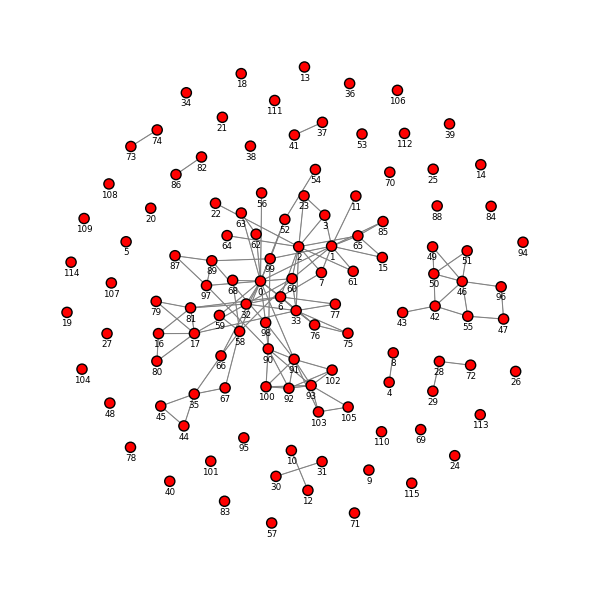

In [62]:
v_labels = [str(i) for i in np.arange(0, 116)]
Graph_list_adj[1].draw(v_label=v_labels)

In [63]:
# from hg cli
Graph_list_cli = []

for hg in Hypergraph_list:
    g = dhg.Graph.from_hypergraph_clique(hg)
    Graph_list_cli.append(g)

Graph_list_cli = np.array(Graph_list_cli)
print('Graph list cli:\n {}'.format(Graph_list_cli))

Graph list cli:
 [Graph(num_v=116, num_e=741) Graph(num_v=116, num_e=776)
 Graph(num_v=116, num_e=778) Graph(num_v=116, num_e=773)
 Graph(num_v=116, num_e=769) Graph(num_v=116, num_e=769)
 Graph(num_v=116, num_e=787) Graph(num_v=116, num_e=772)
 Graph(num_v=116, num_e=758) Graph(num_v=116, num_e=773)
 Graph(num_v=116, num_e=775) Graph(num_v=116, num_e=765)
 Graph(num_v=116, num_e=768) Graph(num_v=116, num_e=786)
 Graph(num_v=116, num_e=790) Graph(num_v=116, num_e=761)
 Graph(num_v=116, num_e=754) Graph(num_v=116, num_e=784)
 Graph(num_v=116, num_e=770) Graph(num_v=116, num_e=777)
 Graph(num_v=116, num_e=772) Graph(num_v=116, num_e=781)
 Graph(num_v=116, num_e=759) Graph(num_v=116, num_e=765)
 Graph(num_v=116, num_e=760) Graph(num_v=116, num_e=776)
 Graph(num_v=116, num_e=761) Graph(num_v=116, num_e=764)
 Graph(num_v=116, num_e=764) Graph(num_v=116, num_e=791)
 Graph(num_v=116, num_e=748) Graph(num_v=116, num_e=750)
 Graph(num_v=116, num_e=769) Graph(num_v=116, num_e=772)
 Graph(num_v=1

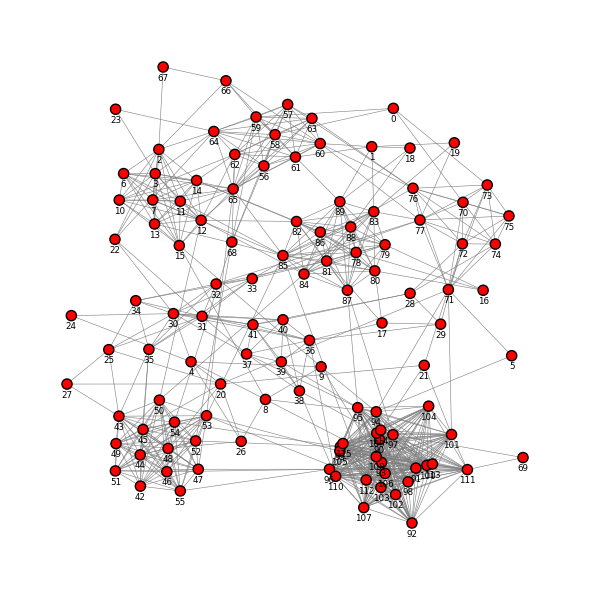

In [64]:
v_labels = [str(i) for i in np.arange(0, 116)]
Graph_list_cli[1].draw(v_label=v_labels)

## GNN model

In [66]:
class GNN(nn.Module):
    r"""The GCN model proposed in `Semi-Supervised Classification with Graph Convolutional Networks <https://arxiv.org/pdf/1609.02907>`_ paper (ICLR 2017).

    Args:
        ``in_channels`` (``int``): :math:`C_{in}` is the number of input channels.
        ``hid_channels`` (``int``): :math:`C_{hid}` is the number of hidden channels.
        ``num_classes`` (``int``): The Number of class of the classification task.
        ``use_bn`` (``bool``): If set to ``True``, use batch normalization. Defaults to ``False``.
        ``drop_rate`` (``float``): Dropout ratio. Defaults to ``0.5``.
    """

    def __init__(self,
                 in_channels: int,
                 hid_channels: int,
                 num_classes: int,
                 mlp_hid_channels: int,
                 use_bn: bool = False,
                 drop_rate: float = 0.3,
                 pooling_strategy: str = "concat"
                 ) -> None:
        super().__init__()
        self.pooling_strategy = pooling_strategy

        self.drop_rate = drop_rate  
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hid_channels, use_bn=use_bn, drop_rate=drop_rate))
        self.layers.append(nn.Dropout(drop_rate))
        self.layers.append(GCNConv(hid_channels, mlp_hid_channels, use_bn=use_bn, is_last=True))

        if pooling_strategy == "concat":
            mlp_input_dim = num_classes * 116  
        else:
            mlp_input_dim = mlp_hid_channels

        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, mlp_hid_channels),
            nn.ReLU(),
            nn.Dropout(drop_rate),
            nn.Linear(mlp_hid_channels, 2)  # Output layer for binary classification
        )

    def forward(self, X: torch.Tensor, g: "dhg.Graph") -> torch.Tensor:
        r"""The forward function.

        Args:
            ``X`` (``torch.Tensor``): Input vertex feature matrix. Size :math:`(N, C_{in})`.
            ``g`` (``dhg.Graph``): The graph structure that contains :math:`N` vertices.
        """
        for layer in self.layers:
            if isinstance(layer, GCNConv):
                X = layer(X, g)
            else:
                X = layer(X)
        if self.pooling_strategy == "mean":
            X = X.mean(dim=0)
        elif self.pooling_strategy == "sum":
            X = X.sum(dim=0)
        elif self.pooling_strategy == "concat":
            X = X.view(-1) 
        out = self.mlp(X)
        return out

## GNN training

In [67]:
# how to build the gnn model
# gnn = GNN(
#         in_channels=116,  
#         hid_channels=32, 
#         num_classes=2,
#         mlp_hid_channels=32,
#         use_bn=False,
#         drop_rate=0.4,
#         pooling_strategy="concat",
#     )

# print(gnn)

GNN(
  (layers): ModuleList(
    (0): GCNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.4, inplace=False)
      (theta): Linear(in_features=116, out_features=32, bias=True)
    )
    (1): Dropout(p=0.4, inplace=False)
    (2): GCNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=232, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [70]:
all_acc_g, all_sen_g, all_spe_g = [], [], []
for fold, (train_index, test_index) in enumerate(kf.split(features, lbl)):
    print(f"Fold {fold + 1}/{K}")
    
    gnn = GNN(
        in_channels=116,  
        hid_channels=116, 
        num_classes=2,
        mlp_hid_channels=64,
        use_bn=False,
        drop_rate=0.6,
        pooling_strategy="mean",
    )
    gnn = gnn.to(device)
    optimizer = optim.Adam(gnn.parameters(), lr=lr, weight_decay=1e-5)
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = lbl[train_index], lbl[test_index]
    G_train, G_test = Graph_list_cli[train_index], Graph_list_cli[test_index]
    
    # Evaluate the model on the test set
    test_acc, test_sen, test_spe = train_and_evaluate(gnn, len(train_index), len(test_index), optimizer, device,
                                                          epoch, y_train, X_train, G_train, y_test, X_test,
                                                          G_test)

    logging.info(f'(Initial Performance Last Epoch) | test_acc={(test_acc * 100):.2f}, '
                 f'test_spe={(test_spe * 100):.2f}, test_sen={(test_sen * 100):.2f}, \n'
                 )
    # Store metrics for this fold
    all_acc_g.append(test_acc)
    all_sen_g.append(test_sen)
    all_spe_g.append(test_spe)

Fold 1/5


INFO:root:(Train) | Epoch=000, loss=0.6908, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 0), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=001, loss=0.6909, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 1), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=002, loss=0.6904, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 2), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=003, loss=0.6911, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 3), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=004, loss=0.6895, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 4), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=005, loss=0.6915, train_acc=53.74, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 5), test_acc=53.71, test_sen=50.00, test_spe=0.00
INFO

Fold 2/5


INFO:root:(Train) | Epoch=000, loss=0.6972, train_acc=49.35, train_sen=51.73, train_spe=82.92
INFO:root:(Train Epoch 0), test_acc=49.43, test_sen=51.33, test_spe=79.01
INFO:root:(Train) | Epoch=001, loss=0.6950, train_acc=53.95, train_sen=52.46, train_spe=32.92
INFO:root:(Train Epoch 1), test_acc=51.15, test_sen=49.28, test_spe=22.22
INFO:root:(Train) | Epoch=002, loss=0.6953, train_acc=53.52, train_sen=49.78, train_spe=0.62
INFO:root:(Train Epoch 2), test_acc=52.30, test_sen=49.00, test_spe=1.23
INFO:root:(Train) | Epoch=003, loss=0.6913, train_acc=53.66, train_sen=49.87, train_spe=0.00
INFO:root:(Train Epoch 3), test_acc=54.02, test_sen=50.62, test_spe=1.23
INFO:root:(Train) | Epoch=004, loss=0.6911, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 4), test_acc=54.02, test_sen=50.62, test_spe=1.23
INFO:root:(Train) | Epoch=005, loss=0.6915, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 5), test_acc=54.02, test_sen=50.62, test_spe=1.23


Fold 3/5


INFO:root:(Train) | Epoch=000, loss=0.6925, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 0), test_acc=53.45, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=001, loss=0.6908, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 1), test_acc=53.45, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=002, loss=0.6917, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 2), test_acc=53.45, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=003, loss=0.6905, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 3), test_acc=53.45, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=004, loss=0.6911, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 4), test_acc=53.45, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=005, loss=0.6898, train_acc=53.80, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 5), test_acc=53.45, test_sen=50.00, test_spe=0.00
INFO

Fold 4/5


INFO:root:(Train) | Epoch=000, loss=0.6933, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 0), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=001, loss=0.6911, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 1), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=002, loss=0.6910, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 2), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=003, loss=0.6918, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 3), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=004, loss=0.6910, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 4), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO:root:(Train) | Epoch=005, loss=0.6903, train_acc=53.66, train_sen=50.00, train_spe=0.00
INFO:root:(Train Epoch 5), test_acc=54.02, test_sen=50.00, test_spe=0.00
INFO

Fold 5/5


INFO:root:(Train) | Epoch=000, loss=0.7013, train_acc=47.06, train_sen=50.48, train_spe=97.21
INFO:root:(Train Epoch 0), test_acc=45.40, test_sen=49.28, test_spe=97.50
INFO:root:(Train) | Epoch=001, loss=0.6944, train_acc=51.08, train_sen=48.59, train_spe=14.55
INFO:root:(Train Epoch 1), test_acc=54.60, test_sen=51.93, test_spe=18.75
INFO:root:(Train) | Epoch=002, loss=0.6923, train_acc=53.37, train_sen=49.96, train_spe=3.41
INFO:root:(Train Epoch 2), test_acc=55.17, test_sen=51.34, test_spe=3.75
INFO:root:(Train) | Epoch=003, loss=0.6926, train_acc=53.52, train_sen=49.89, train_spe=0.31
INFO:root:(Train Epoch 3), test_acc=54.60, test_sen=50.62, test_spe=1.25
INFO:root:(Train) | Epoch=004, loss=0.6944, train_acc=53.37, train_sen=49.86, train_spe=1.86
INFO:root:(Train Epoch 4), test_acc=54.60, test_sen=50.62, test_spe=1.25
INFO:root:(Train) | Epoch=005, loss=0.6894, train_acc=53.80, train_sen=50.15, train_spe=0.31
INFO:root:(Train Epoch 5), test_acc=54.02, test_sen=50.00, test_spe=0.00


In [71]:
# Calculate average performance metrics across all folds
avg_acc_g = np.mean(all_acc_g) * 100
avg_sen_g = np.mean(all_sen_g) * 100
avg_spe_g = np.mean(all_spe_g) * 100

# Print average performance metrics
avg_result_str = f'(Average Performance Across Folds) | ' \
                 f'avg_acc={avg_acc_g:.2f} +- {np.std(all_acc_g) * 100:.2f}, ' \
                 f'avg_sen={avg_sen_g:.2f} +- {np.std(all_sen_g) * 100:.2f},' \
                 f'avg_spe={avg_spe_g:.2f} +- {np.std(all_spe_g) * 100:.2f}, \n' 
logging.info(avg_result_str)

# Calculate the p-value for the accuracy across folds
t_stat, p_value = ttest_1samp(all_acc_g, 0.5)  # Null hypothesis: mean accuracy is 50%
logging.info(f'p-value for accuracy against 50% baseline: {p_value:.4f}')

if p_value < 0.05:
    logging.info("The accuracy is significantly different from 50% (p < 0.05)")
else:
    logging.info("No significant difference from 50% accuracy (p >= 0.05)")

INFO:root:(Average Performance Across Folds) | avg_acc=62.92 +- 0.64, avg_sen=62.16 +- 0.79,avg_spe=51.87 +- 6.97, 

INFO:root:p-value for accuracy against 50% baseline: 0.0000
INFO:root:The accuracy is significantly different from 50% (p < 0.05)


End!